# Assignment 1 

## Question 1. Identifying the top 5 Political Action Committees (PACs), or rather, super-PACs, that supported each of the two presidential candidates, giving the amount of money raised and spent by each one of them.


Importing necessary libraries.



In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib
import re
from collections import defaultdict

pd.set_option("display.max_columns", None)


All datasets that need to be downloaded should be placed in the same directory as this notebook.
Importing headers and csv file from Contributions from committees to candidates from https://www.fec.gov/files/bulk-downloads/2016/pas216.zip.
Making the TRANSACTION_AMT a float value.



In [2]:
commisheaders = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv')
headers = commisheaders.columns.tolist()
datatypes2 = {header: np.str for header in headers}
datatypes2['TRANSACTION_AMT'] = np.float


commis = pd.read_csv('pas216.zip', sep = "|", index_col = False, names = headers,dtype = datatypes2)


commis.sample()

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,CAND_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
471077,C90011156,N,YE,G2016,201701319042157678,24E,ORG,CANDLEWOOD SUITES-RALEIGH,RALEIGH,NC,276123324,NaN,NaN,09222016,9.0,P00003392,P00003392,VN7CZA3V1M9,1144686,NaN,NaN,4020920171370101773




Reading the candidates master header file and csv file from https://www.fec.gov/files/bulk-downloads/2016/cn16.zip. Limiting dateframe to 2016 election year and presidential candidates only.




In [3]:
cnheaders2 = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/cn_header_file.csv')
cnheaders = cnheaders2.columns.tolist()
cn = pd.read_csv('cn16.zip', sep = "|", index_col = False, names = cnheaders)
cn = cn.loc[(cn['CAND_ELECTION_YR'] == 2016) & (cn['CAND_OFFICE'] == 'P') & (cn['CAND_STATUS'] == 'C')]

cn.sample()

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP
5636,P60016342,"DE LA FUENTE, ROQUE ROCKY",DEM,2016,US,P,0.0,O,C,C00588426,5440 MOREHOUSE DRIVE # 45,NaN,SAN DIEGO,CA,92121.0


Merging two dataframes. 

In [4]:
commis = pd.merge(commis, 
               cn[['CAND_ID', 'CAND_NAME']], 
               on='CAND_ID',
               how='inner')
commis.sample()

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,CAND_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_NAME
82844,C90011156,N,Q3,G2016,201610129032251436,24A,IND,"BADARACO, CARLOS",ORLANDO,FL,328357062,NaN,NaN,08172016,34.0,P80001571,P80001571,VN7CZA2CNM1,1104329,NaN,NaN,4101320161340914446,"TRUMP, DONALD J. / MICHAEL R. PENCE"


In [5]:
(commis['TRANSACTION_AMT'] > 0).value_counts()

True     119552
False       526
Name: TRANSACTION_AMT, dtype: int64

Limiting transaction amount to only positive floats.

In [6]:

commis = commis[commis['TRANSACTION_AMT'] > 0]



Simplifying candidates names.

In [7]:
commis.loc[commis['CAND_NAME'] == 'TRUMP, DONALD J. / MICHAEL R. PENCE ', 'CAND_NAME'] = 'TRUMP, DONALD J.'
commis.loc[commis['CAND_NAME'] == 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE', 'CAND_NAME'] = 'CLINTON, HILLARY RODHAM'

commis['CAND_NAME'].unique()




array(['CLINTON, HILLARY RODHAM', "O'MALLEY, MARTIN JOSEPH",
       'CRUZ, RAFAEL EDWARD "TED"', 'FIORINA, CARLY', 'GRAHAM, LINDSEY O',
       'TRUMP, DONALD J.', 'JINDAL, BOBBY', 'PAUL, RAND',
       'KASICH, JOHN R', 'BUSH, JEB', 'HUCKABEE, MIKE', 'WALKER, SCOTT',
       'SANDERS, BERNARD', 'PATAKI, GEORGE E', 'CHRISTIE, CHRISTOPHER J',
       'SANTORUM, RICHARD J.', 'CARSON, BENJAMIN S SR MD',
       'PERRY, JAMES R (RICK)', 'JOHNSON, GARY / WILLIAM "BILL" WELD',
       'CASTLE, DARRELL LANE', 'MCMULLIN, EVAN / MINDY FINN',
       'STEIN, JILL', 'PETERSEN, AUSTIN WADE'], dtype=object)

Creating new dataframe that contains only the two main candidates we are interested in.
Swapping names if transactions are of type '24A' because these are transactions spent to oppose the other candidate.
Limiting entity type to PAC, COM and CCM.

In [8]:
pacs = commis.loc[commis['ENTITY_TP'] == 'IND']

pac_trcl = commis.loc[commis['CAND_NAME'].isin(['TRUMP, DONALD J.', 'CLINTON, HILLARY RODHAM'])].copy()
pac_trcl.loc[(pac_trcl['CAND_NAME'] == 'TRUMP, DONALD J.')&(pac_trcl['TRANSACTION_TP'] == '24A'), 'CAND_NAME'] = 'CLINTON, HILLARY RODHAM'
pac_trcl = pac_trcl.loc[(pac_trcl['ENTITY_TP'] == 'PAC') | (pac_trcl['ENTITY_TP'] == 'COM')| (pac_trcl['ENTITY_TP'] == 'CCM')]
pac_trcl

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,CAND_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_NAME
0,C00553966,N,MY,P2016,201507309000452734,24K,COM,HILLARY FOR AMERICA,NEW YORK,NY,10185,NaN,NaN,06112015,2700.0,C00575795,P00003392,BF18096EB39184187AAD,1018911,NaN,NaN,4073020151248060298,"CLINTON, HILLARY RODHAM"
1,C00574228,N,MY,P2016,201507279000425873,24K,CCM,HILLLARY FOR AMERICA,NEW YORK,NY,10185,NaN,NaN,04162015,500.0,C00575795,P00003392,SB23.4120,1018172,NaN,NaN,4072820151247971455,"CLINTON, HILLARY RODHAM"
2,C00574228,N,MY,P2016,201507279000425873,24K,CCM,HILLLARY FOR AMERICA,NEW YORK,NY,10185,NaN,NaN,05062015,2200.0,C00575795,P00003392,SB23.4122,1018172,NaN,NaN,4072820151247971456,"CLINTON, HILLARY RODHAM"
3,C00540955,N,MY,P2016,201507319000536095,24K,CCM,HILLARY FOR AMERICA,NEW YORK,NY,10185,NaN,NaN,06222015,5000.0,C00575795,P00003392,D528070,1020030,NaN,NaN,4080320151248229024,"CLINTON, HILLARY RODHAM"
4,C00342048,N,MY,P2016,201507319000536286,24K,CCM,HILLARY FOR AMERICA,NEW YORK,NY,101851367,NaN,NaN,05052015,5000.0,C00575795,P00003392,D512274,1020033,NaN,NaN,4080320151248229297,"CLINTON, HILLARY RODHAM"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87619,C00524454,A,30G,G2016,201701319041576113,24K,CCM,"DONALD J. TRUMP FOR PRESIDENT, INC.",NEW YORK,NY,10022,NaN,NaN,11022016,5000.0,C00580100,P80001571,SB23.39544,1143957,NaN,NaN,4020220171369307364,"TRUMP, DONALD J."
113041,C00321158,A,Q2,G2016,201702079044302297,24K,CCM,"DONALD J. TRUMP FOR PRESIDENT, INC.",NEW YORK,NY,10022,NaN,NaN,06102016,5000.0,C00580100,P80001571,SB23.16123,1147961,NaN,NaN,4020820171369965242,"TRUMP, DONALD J."
113078,C00495028,A,30G,G2016,201702079044302043,24A,CCM,TARGETED PLATFORM MEDIA LLC,ANNAPOLIS,MD,214034909,NaN,NaN,10262016,56411.0,P80001571,P80001571,VN7GDA6V120,1147957,NaN,NaN,4020920171370185031,"CLINTON, HILLARY RODHAM"
113268,C00523621,A,12G,G2016,201705019053490621,24A,PAC,1199 SERVICE EMPLOYEES INT'L UNION FEDERAL POL...,NY,NY,10036,NaN,NaN,10112016,362138.0,P80001571,P80001571,D368173,1160882,NaN,NaN,4050220171400789572,"CLINTON, HILLARY RODHAM"


## Top 5 PACS for Donald Trump

In [9]:

trumpmapping = {
    'DONALD J. TRUMP FOR PRESIDENT INC.' : 'DONALD J. TRUMP FOR PRESIDENT, INC.',
    'DONALD J TRUMP FOR PRESIDENT INC.' : 'DONALD J. TRUMP FOR PRESIDENT, INC.',
    'DONALD J. TRUMP FOR PRESIDENT INC' : 'DONALD J. TRUMP FOR PRESIDENT, INC.',
    'DONALD J TRUMP FOR PRESIDENT INC' : 'DONALD J. TRUMP FOR PRESIDENT, INC.',
    'TRUMP FOR AMERICA, INC.' : 'TRUMP FOR AMERICA',
    'DONALD J TRUMP FOR PRESIDENT INC' : 'DONALD J. TRUMP FOR PRESIDENT, INC.',
    'DONALD J. TRUMP FOR PRESIDENT': 'DONALD J. TRUMP FOR PRESIDENT, INC.',
    'DONALD J TRUMP FOR PRESIDENT' : 'DONALD J. TRUMP FOR PRESIDENT, INC.'
}


f = lambda x : trumpmapping.get(x,x)
pac_trcl.loc[:,'NAME'] = pac_trcl.loc[:,'NAME'].map(f)




trumppac = pac_trcl[pac_trcl['CAND_NAME'] == 'TRUMP, DONALD J.']\
    .groupby('NAME').sum()\
    .sort_values(by='TRANSACTION_AMT', ascending=False).head()
trumppac

,TRANSACTION_AMT
NAME,
"DONALD J. TRUMP FOR PRESIDENT, INC.",164621.0
TRUMP VICTORY,125000.0
TRUMP FOR AMERICA,10000.0
"TRUMP, DONALD J. / MICHAEL R. PENCE",1000.0
BRING BACK AMERICAN OPPORTUNITY,116.0


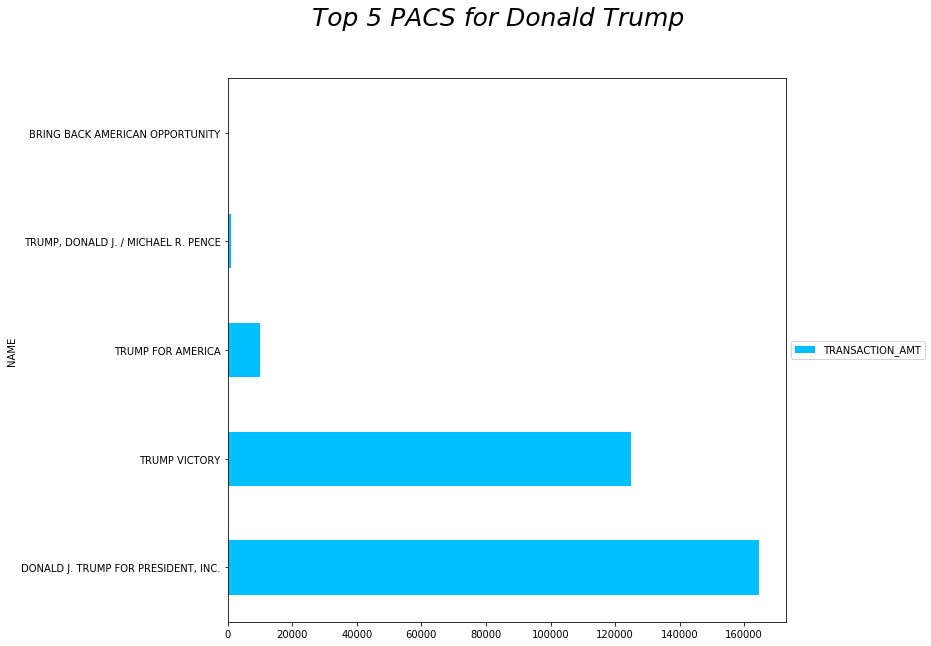

In [10]:
f = plt.figure(figsize=(10,10))
trumppac.plot(kind='barh', stacked=True, ax=f.gca(), color=('deepskyblue', 'salmon'))
f.suptitle('Top 5 PACS for Donald Trump',fontsize = 25, style = 'italic')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Top 5 PACS for Hillary Clinton

In [11]:
hillarypac = pac_trcl[pac_trcl['CAND_NAME'] == 'CLINTON, HILLARY RODHAM']\
    .groupby('NAME').sum()\
    .sort_values(by='TRANSACTION_AMT', ascending=False).head(5)
hillarypac

,TRANSACTION_AMT
NAME,
HILLARY FOR AMERICA,1314503.0
PRIORITIES USA ACTION,767182.0
1199 SERVICE EMPLOYEES INT'L UNION FEDERAL POLITICAL ACTION FUND,603563.0
WOMEN VOTE!,162814.0
"TERRIS, BARNES, WALTERS",119198.0


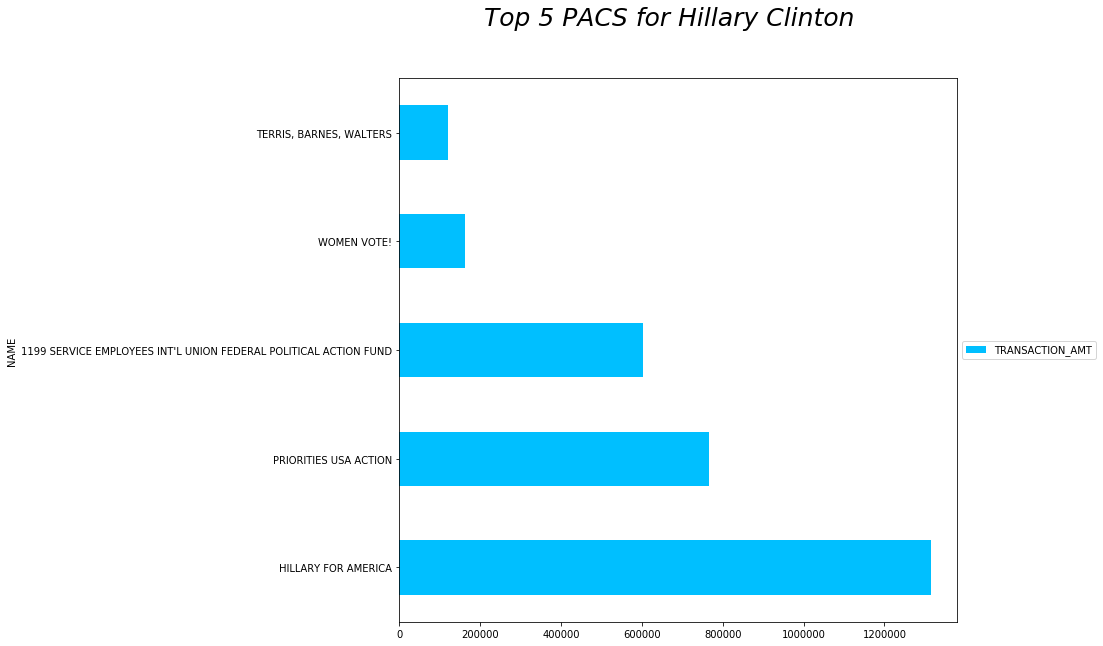

In [12]:
f = plt.figure(figsize=(10,10))
hillarypac.plot(kind='barh', stacked=True, ax=f.gca(), color=('deepskyblue', 'salmon'))
f.suptitle('Top 5 PACS for Hillary Clinton',fontsize = 25, style = 'italic')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Question 2. Identifying the top 10 individual donors (i.e., persons) for each of the two presidential candidates and the amount they spent.


 Downloading headers and the dataset for individual donations from https://www.fec.gov/files/bulk-downloads/2016/indiv16.zip. Making the transaction amount a float value.



In [13]:
indheaders = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv')
indheader = indheaders.columns.tolist()
datatypes2 = {header: np.str for header in indheader}
datatypes2['TRANSACTION_DT'] = np.str
datatypes2['TRANSACTION_AMT'] = np.float
indiv = pd.read_csv('indiv16/itcont.txt', sep = "|", index_col = False, names = indheader, dtype= datatypes2)
indiv.sample()

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID
18859648,C00337733,A,30G,P,201704209052396885,15,IND,"INIGUEZ, WILLAN ROBERTO",NEW YORK,NY,10032,CALVIN MAINTENANCE,LABORER,11232016,25.0,NaN,C10481775,1159659,NaN,* PAYROLL DEDUCTION:,4042420171400274809


Getting the headers for the committees from https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cm_header_file.csv.

In [14]:
cm_headers_df =  pd.read_csv('https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cm_header_file.csv')
cm_headers_df

,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID


Reading the committee master csv file from https://www.fec.gov/files/bulk-downloads/2016/cm16.zip

In [15]:
cm_headers = cm_headers_df.columns.tolist()
cm_headers
cm = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cm16.zip', 
                  sep="|", 
                  index_col=False, 
                  names=cm_headers)
print(cm.shape)
cm.head(5)

(17650, 15)


,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID
0,C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,NaN,NaN
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,NaN,M,M,AMERICAN MEDICAL ASSOCIATION,NaN
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,NaN,OKLAHOMA CITY,OK,73107,U,N,NaN,Q,L,TEAMSTERS LOCAL UNION 886,NaN
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,NaN,TOPEKA,KS,66612,U,Q,UNK,Q,T,NaN,NaN
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",NaN,INDIANAPOLIS,IN,46202,U,Q,NaN,Q,M,NaN,NaN


Reading the candidates dataset from  https://www.fec.gov/files/bulk-downloads/2016/cn16.zip

In [16]:
cn_headers_df = pd.read_csv(
    'https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cn_header_file.csv')

cn_headers = cn_headers_df.columns.tolist()
cn = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cn16.zip', 
                  sep="|", 
                  index_col=False, 
                  names=cn_headers)
cn.head(5)

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP
0,H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0.0,C,N,C00525261,P.O. BOX 1092,NaN,ANCHOR POINT,AK,99556.0
1,H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2.0,I,C,C00462143,PO BOX 195,NaN,MONTGOMERY,AL,36101.0
2,H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2.0,C,N,NaN,1465 W OVERBROOK RD,NaN,MILLBROOK,AL,36054.0
3,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,H,5.0,NaN,P,C00239038,PO BOX 2621,NaN,HUNTSVILLE,AL,35804.0
4,H0AL05163,"BROOKS, MO",REP,2016,AL,H,5.0,I,C,C00464149,7610 FOXFIRE DRIVE,NaN,HUNTSVILLE,AL,35802.0


Limiting candidates to election year 2016 and to presidential candidates only.

In [17]:
cn = cn.loc[(cn['CAND_ELECTION_YR'] == 2016) & (cn['CAND_OFFICE'] == 'P') & (cn['CAND_STATUS'] == 'C')]
print(cn.shape)
cn.head(5)

(72, 15)


,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_ST1,CAND_ST2,CAND_CITY,CAND_ST,CAND_ZIP
4367,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",DEM,2016,US,P,0.0,O,C,C00575795,NaN,NaN,NEW YORK,NY,NaN
4377,P00003962,"SCHRINER, JOSEPH CHARLES",UNK,2016,US,P,0.0,O,C,C00385153,542 S MAIN ST,NaN,BLUFFTON,OH,45817.0
4379,P00004275,"BROWN, HARLEY D",NNE,2016,US,P,0.0,O,C,C00569442,6086 HAPPY LANE,NaN,NAMPA,ID,83686.0
4385,P00004861,"BICKELMEYER, MICHAEL",REP,2016,US,P,0.0,O,C,C00553206,399 PEARL ROAD,NaN,BRUNSWICK,OH,44212.0
4478,P20002671,"JOHNSON, GARY / WILLIAM ""BILL"" WELD",LIB,2016,US,P,0.0,O,C,C00605568,NaN,NaN,SALT LAKE CITY,UT,NaN


Merging the individual donations with the committees

In [18]:
indiv = pd.merge(indiv, 
               cm[['CMTE_ID', 'CAND_ID']], 
               on='CMTE_ID',
               how='inner')

print(indiv.shape)
indiv.head(5)


(20468513, 22)


,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID
0,C00088591,N,M3,P,15970306895,15,IND,"BURCH, MARY K.",FALLS CHURCH,VA,220424511,NORTHROP GRUMMAN,VP PROGRAM MANAGEMENT,02132015,500.0,NaN,2A8EE0688413416FA735,998834,NaN,NaN,4032020151240885624,NaN
1,C00088591,N,M3,P,15970306960,15,IND,"KOUNTZ, DONALD E.",FALLS CHURCH,VA,220424511,NORTHROP GRUMMAN,DIR PROGRAMS,02132015,200.0,NaN,20150211113220-479,998834,NaN,NaN,4032020151240885819,NaN
2,C00088591,N,M3,P,15970306960,15,IND,"KOUNTZ, DONALD E.",FALLS CHURCH,VA,220424511,NORTHROP GRUMMAN,DIR PROGRAMS,02272015,200.0,NaN,20150225112333-476,998834,NaN,NaN,4032020151240885820,NaN
3,C00088591,N,M3,P,15970306915,15,IND,"DOSHI, NIMISH M.",FALLS CHURCH,VA,220424511,NORTHROP GRUMMAN,VP AND CFO,02132015,200.0,NaN,20150309_2943,998834,NaN,NaN,4032020151240885683,NaN
4,C00088591,N,M3,P,15970306915,15,IND,"DOSHI, NIMISH M.",FALLS CHURCH,VA,220424511,NORTHROP GRUMMAN,VP AND CFO,02272015,200.0,NaN,20150224153748-2525,998834,NaN,NaN,4032020151240885684,NaN


Merging the resulting dataframe with the candidates.

In [19]:
indiv = pd.merge(indiv, 
               cn[['CAND_ID', 'CAND_NAME']], 
               on='CAND_ID',
               how='inner')

print(indiv.shape)
indiv.head(5)

(4985559, 23)


,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_NAME
0,C00573816,N,Q1,P2016,15951155559,15C,CAN,"EVERSON, MARK",GAUTIER,MS,395537350,ALLIANTGROUP,VICE CHAIRMAN,03032015,25000.0,P60005972,A300D7FFF3C6B4C1FBC7,1003605,NaN,NaN,4041620151241914282,P60005972,"EVERSON, MARK"
1,C00573816,N,Q1,P2016,15951155558,15C,CAN,"EVERSON, MARK",GAUTIER,MS,395537350,ALLIANTGROUP,VICE CHAIRMAN,02142015,3393.0,P60005972,AA23B1CE2366A4F589F2,1003605,NaN,NaN,4041620151241914279,P60005972,"EVERSON, MARK"
2,C00573816,N,Q1,P2016,15951155558,15C,CAN,"EVERSON, MARK",GAUTIER,MS,395537350,ALLIANTGROUP,VICE CHAIRMAN,02212015,2321.0,P60005972,AADE0A1410AE94F3EA19,1003605,NaN,NaN,4041620151241914280,P60005972,"EVERSON, MARK"
3,C00573816,N,Q1,P2016,15951155559,15C,CAN,"EVERSON, MARK",GAUTIER,MS,395537350,ALLIANTGROUP,VICE CHAIRMAN,02282015,933.0,P60005972,A846499ED6AD84A66AF9,1003605,NaN,NaN,4041620151241914281,P60005972,"EVERSON, MARK"
4,C00573816,N,Q1,P2016,15951155559,15C,CAN,"EVERSON, MARK",GAUTIER,MS,395537350,ALLIANTGROUP,VICE CHAIRMAN,03072015,15000.0,P60005972,A9453947CF0B84401B29,1003605,NaN,NaN,4041620151241914283,P60005972,"EVERSON, MARK"


Limiting values to positive floats, simplyfying names, and limiting entity type to IND(Individuals).

In [20]:
(indiv['TRANSACTION_AMT'] > 0).value_counts()
indiv = indiv[indiv['TRANSACTION_AMT'] > 0]
indiv.loc[indiv['CAND_NAME'] == 'TRUMP, DONALD J. / MICHAEL R. PENCE ', 'CAND_NAME'] = 'TRUMP, DONALD J.'
indiv.loc[indiv['CAND_NAME'] == 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE', 'CAND_NAME'] = 'CLINTON, HILLARY RODHAM'
indiv_t = indiv.loc[indiv['CAND_NAME'].isin(['TRUMP, DONALD J.', 'CLINTON, HILLARY RODHAM'])].copy()
indiv_t.loc[indiv_t['ENTITY_TP'] == 'IND']


,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_NAME
620407,C00575795,A,Q2,P2016,201509039001600102,15,IND,"ELIAS, JOHN",WASHINGTON,DC,200053743,U.S. DEPARTMENT OF JUSTICE,ATTORNEY,06112015,100.0,NaN,C223180,1024052,NaN,NaN,4090920151249600961,P00003392,"CLINTON, HILLARY RODHAM"
620408,C00575795,A,Q2,P2016,201509039001600101,15,IND,"CLARY, CAROLE",DESTIN,FL,325405205,"CPR OF DESTIN, INC.",VP/DIRECTOR OF OPERATIONS,06152015,50.0,NaN,C240090,1024052,NaN,NaN,4090920151249600958,P00003392,"CLINTON, HILLARY RODHAM"
620409,C00575795,A,Q2,P2016,201509039001600101,15,IND,"FEW, MELANIE",DALLAS,TX,752011123,ACE CASH EXPRESS,MARKETING,04122015,5.0,NaN,C17450,1024052,NaN,NaN,4090920151249600959,P00003392,"CLINTON, HILLARY RODHAM"
620410,C00575795,A,Q2,P2016,201509039001600101,15,IND,"SPURLOCK, MICHAEL",NASHVILLE,TN,372036615,NaN,NOT EMPLOYED,06132015,50.0,NaN,C234270,1024052,NaN,NaN,4090920151249600960,P00003392,"CLINTON, HILLARY RODHAM"
620411,C00575795,A,Q2,P2016,201509039001600102,15,IND,"SHIFTON, CONSTANCE",CHERRY HILL,NJ,080031314,SELF-EMPLOYED,EDUCATIONAL ADVISOR,06122015,50.0,NaN,C229360,1024052,NaN,NaN,4090920151249600962,P00003392,"CLINTON, HILLARY RODHAM"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350452,C00580100,A,30G,G2016,201906289150379788,15E,IND,"FINKEL, MARK",GREENWOOD VILLAGE,CO,80121,SELF-EMPLOYED,MANAGER,10202016,240.0,NaN,SA18.105892,1335965,X,NaN,4071020191659173465,P80001571,"TRUMP, DONALD J."
3350453,C00580100,A,30G,G2016,201906289150379788,15E,IND,"FINKEL, MARK",GREENWOOD VILLAGE,CO,80121,SELF-EMPLOYED,MANAGER,10272016,240.0,NaN,SA18.105893,1335965,X,NaN,4071020191659173466,P80001571,"TRUMP, DONALD J."
3350454,C00580100,A,30G,G2016,201906289150381271,15E,IND,"GERINO, DOROTHY MS.",BELLEVILLE,NJ,07109,INFORMATION REQUESTED,INFORMATION REQUESTED,10072016,240.0,NaN,SA18.114226,1335965,X,NaN,4071020191659177915,P80001571,"TRUMP, DONALD J."
3350455,C00580100,A,30G,G2016,201906289150384232,15E,IND,"HEWELL, JAMES",SAINT SIMONS ISLAND,GA,31522,RETIRED,RETIRED,10032016,400.0,NaN,SA18.130786,1335965,X,NaN,4071020191659186797,P80001571,"TRUMP, DONALD J."


## Top 10 individual donors for Hillary Clinton.

In [21]:
hillindiv = indiv_t[indiv_t['CAND_NAME'] == 'CLINTON, HILLARY RODHAM']\
    .groupby('NAME').sum()\
    .sort_values(by='TRANSACTION_AMT', ascending=False).head(10)
hillindiv


,TRANSACTION_AMT
NAME,
"CLINTON, HILLARY RODHAM",1450306.0
"RUNYAN, R. BRADLEY",35100.0
"SMITH, MICHAEL",33909.0
"BURNS, URSULA",32400.0
"FRIEDMAN, JANELLE",32400.0
"ELLING, MARTIN",32399.0
"COHEN, DAVID",27459.0
"BROWN, MICHAEL",25903.0
"SMITH, DAVID",24613.0


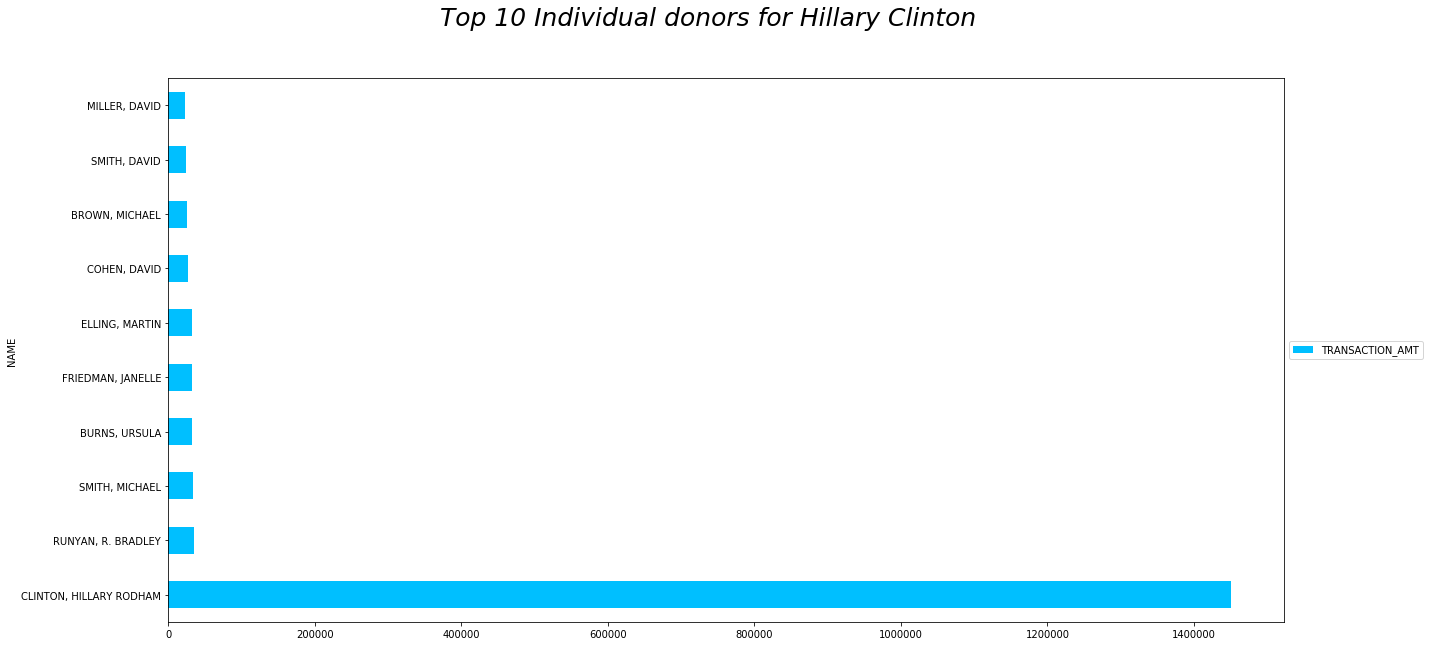

In [22]:
f = plt.figure(figsize=(20,10))
hillindiv.plot(kind='barh', stacked=True, ax=f.gca(), color=('deepskyblue', 'salmon'))
f.suptitle('Top 10 Individual donors for Hillary Clinton',fontsize = 25, style = 'italic')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Top 10 individual donors for Donald Trump.

In [23]:
trumpindiv = indiv_t[indiv_t['CAND_NAME'] == 'TRUMP, DONALD J.']\
    .groupby('NAME').sum()\
    .sort_values(by='TRANSACTION_AMT', ascending=False).head(10)
trumpindiv

,TRANSACTION_AMT
NAME,
"TRUMP, DONALD J",10033637.0
"TRUMP, DONALD J.",6532038.0
"TRUMP, DONALD J J.",2067482.0
"BOCH, ERNIE",171172.0
"TREIBEL, RANDY",52352.0
"HAMLIN, TRISH",38400.0
"HYDE, ROBERT",34085.0
"WILLIAMS, DAVID",29572.0
"SMITH, JAMES",26818.0


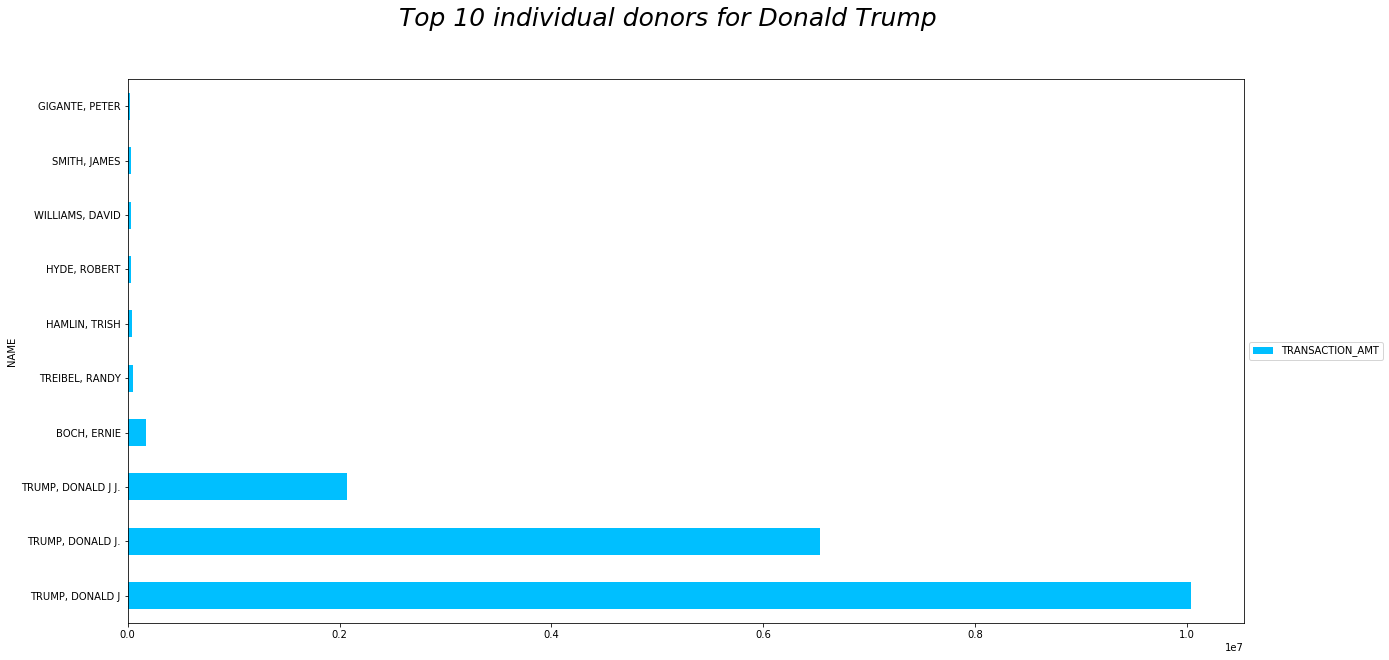

In [24]:
f = plt.figure(figsize=(20,10))
trumpindiv.plot(kind='barh', stacked=True, ax=f.gca(), color=('deepskyblue', 'salmon'))
f.suptitle('Top 10 individual donors for Donald Trump',fontsize = 25, style = 'italic')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Question 3. Investigating the chronological evolution of the contributions made to and the expenditures made by the campaigns.

We are going to work with the dataframe indiv_t from the previous question. We modify the transaction date to only contain the month.

In [25]:

indiv_t['TRANSACTION_DT'] = indiv_t['TRANSACTION_DT'].apply(lambda x : x[0]+x[1])
indiv_t.sample(10)

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_NAME
1549317,C00575795,A,M10,G2016,201701099041080001,15,IND,"RUGARBER, LAURA",JERSEY CITY,NJ,073023485,SAPIENT GLOBAL MARKETS,BUSINESS CONSULTANT,09,10.0,NaN,C10856524,1137625,NaN,NaN,4011120171366004238,P00003392,"CLINTON, HILLARY RODHAM"
1774318,C00575795,A,M10,G2016,201701099041065146,15,IND,"FOGARTY, KIM",LAGUNA NIGUEL,CA,926774242,ELLISON,LAWYER,09,5.0,NaN,C9927083,1137625,NaN,NaN,4011120171365959671,P00003392,"CLINTON, HILLARY RODHAM"
2984690,C00575795,A,M6,P2016,201607309022081300,22Y,IND,"JAUNDRILL, CATHERINE",SHELTON,CT,064842833,NaN,NaN,05,5.0,NaN,D200162,1091720,NaN,NaN,4080320161307922065,P00003392,"CLINTON, HILLARY RODHAM"
860982,C00575795,A,30G,G2016,201702149049456960,15,IND,"KJENDAL-OLSEN, VICKI",MONTGOMERY,IL,605382614,NaN,RETIRED,11,25.0,NaN,C14752550,1148953,NaN,NaN,4021720171371203956,P00003392,"CLINTON, HILLARY RODHAM"
2194134,C00575795,A,M9,G2016,201611239037250345,15,IND,"HADDIX, DAVID",TAMPA,FL,336123668,"FANCY THAT DOG GROOMING, INC.",INVESTOR,08,8.0,NaN,C9009001,1126762,NaN,NaN,4113020161355018183,P00003392,"CLINTON, HILLARY RODHAM"
3209009,C00580100,N,M2,P2016,201602209008575834,15,IND,"RATHBUN, BILL",BEAUFORT,SC,29907,RETIRED,RETIRED,01,114.0,NaN,SA17A.269246,1051572,NaN,NaN,4022320161272728845,P80001571,"TRUMP, DONALD J."
796612,C00575795,A,30G,G2016,201702149049550519,15,IND,"FREYDOONNEJAD, SIAMAK",NEW YORK,NY,100025360,NOT EMPLOYED,SOFTWARE ENGINEER,10,25.0,NaN,C13946955,1148953,NaN,NaN,4021720171371484631,P00003392,"CLINTON, HILLARY RODHAM"
1245071,C00575795,A,30G,G2016,201702149049593116,15,IND,"RICKETTS, BARBARA",RALEIGH,NC,276033079,NaN,NOT EMPLOYED,11,25.0,NaN,C15660168,1148953,NaN,NaN,4021720171371612424,P00003392,"CLINTON, HILLARY RODHAM"
2950806,C00575795,A,M5,P2016,201607309022002116,15,IND,"FISHER, LARA",GAITHERSBURG,MD,208782781,THE ENCIMA GROUP,SENIOR ANALYST,04,19.0,NaN,C4509768,1091718,NaN,NaN,4080320161308055153,P00003392,"CLINTON, HILLARY RODHAM"
1240998,C00575795,A,30G,G2016,201702149049598097,15,IND,"KAIL, NANCY",CARLSBAD,CA,920091900,SAN DIEGO STATE UNIVERSITY,TRAINING COORDINATOR,10,1.0,NaN,C14384298,1148953,NaN,NaN,4021720171371627365,P00003392,"CLINTON, HILLARY RODHAM"


We create one dataframe for Trump donations and one for Hillary.

In [26]:
trumpmonths = indiv_t.loc[indiv_t['CAND_NAME'].isin(['TRUMP, DONALD J.'])].copy()
hillarymonths = indiv_t.loc[indiv_t['CAND_NAME'].isin(['CLINTON, HILLARY RODHAM'])].copy()
hillarymonths

,CMTE_ID,AMNDT_IND,RPT_TP,TRANSACTION_PGI,IMAGE_NUM,TRANSACTION_TP,ENTITY_TP,NAME,CITY,STATE,ZIP_CODE,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,OTHER_ID,TRAN_ID,FILE_NUM,MEMO_CD,MEMO_TEXT,SUB_ID,CAND_ID,CAND_NAME
620407,C00575795,A,Q2,P2016,201509039001600102,15,IND,"ELIAS, JOHN",WASHINGTON,DC,200053743,U.S. DEPARTMENT OF JUSTICE,ATTORNEY,06,100.0,NaN,C223180,1024052,NaN,NaN,4090920151249600961,P00003392,"CLINTON, HILLARY RODHAM"
620408,C00575795,A,Q2,P2016,201509039001600101,15,IND,"CLARY, CAROLE",DESTIN,FL,325405205,"CPR OF DESTIN, INC.",VP/DIRECTOR OF OPERATIONS,06,50.0,NaN,C240090,1024052,NaN,NaN,4090920151249600958,P00003392,"CLINTON, HILLARY RODHAM"
620409,C00575795,A,Q2,P2016,201509039001600101,15,IND,"FEW, MELANIE",DALLAS,TX,752011123,ACE CASH EXPRESS,MARKETING,04,5.0,NaN,C17450,1024052,NaN,NaN,4090920151249600959,P00003392,"CLINTON, HILLARY RODHAM"
620410,C00575795,A,Q2,P2016,201509039001600101,15,IND,"SPURLOCK, MICHAEL",NASHVILLE,TN,372036615,NaN,NOT EMPLOYED,06,50.0,NaN,C234270,1024052,NaN,NaN,4090920151249600960,P00003392,"CLINTON, HILLARY RODHAM"
620411,C00575795,A,Q2,P2016,201509039001600102,15,IND,"SHIFTON, CONSTANCE",CHERRY HILL,NJ,080031314,SELF-EMPLOYED,EDUCATIONAL ADVISOR,06,50.0,NaN,C229360,1024052,NaN,NaN,4090920151249600962,P00003392,"CLINTON, HILLARY RODHAM"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136769,C00575795,A,M2,P2016,201607059020187995,22Y,IND,"GALLAGHER, SARAH",WASHINGTON,DC,200012872,NaN,NaN,01,56.0,NaN,D106178,1081057,NaN,NaN,4070720161305499723,P00003392,"CLINTON, HILLARY RODHAM"
3136770,C00575795,A,M2,P2016,201607059020187995,22Y,IND,"FALLS, MARY",TALLAHASSEE,FL,323123732,NaN,NaN,01,10.0,NaN,D106298,1081057,NaN,NaN,4070720161305499725,P00003392,"CLINTON, HILLARY RODHAM"
3136771,C00575795,A,M2,P2016,201607059020187995,22Y,IND,"KRANTZ, JANE",SANTA MONICA,CA,904041570,NaN,NaN,01,25.0,NaN,D106318,1081057,NaN,NaN,4070720161305499727,P00003392,"CLINTON, HILLARY RODHAM"
3136772,C00575795,A,M2,P2016,201607059020187996,22Y,IND,"FIELDSTEAD, LIZ",SUMMERVILLE,SC,294865385,NaN,NaN,01,100.0,NaN,D106358,1081057,NaN,NaN,4070720161305499729,P00003392,"CLINTON, HILLARY RODHAM"


We create two pivot tables ,one for each candidate. We are summing up all the transaction amounts for each month of the year.

In [27]:
trumpmonths2 = trumpmonths.pivot_table(index = 'TRANSACTION_DT', columns = 'CAND_NAME' , values = 'TRANSACTION_AMT', aggfunc = 'sum')
hillarymonths2 = hillarymonths.pivot_table(index = 'TRANSACTION_DT', columns = 'CAND_NAME' , values = 'TRANSACTION_AMT', aggfunc = 'sum')
hillarymonths2

CAND_NAME,"CLINTON, HILLARY RODHAM"
TRANSACTION_DT,
01,9260953.0
02,13303220.0
03,12597862.0
04,28547550.0
05,27311440.0
06,32159884.0
07,27351601.0
08,24883696.0
09,39189820.0


Creating timeplot to represent the campaign donations timeline.

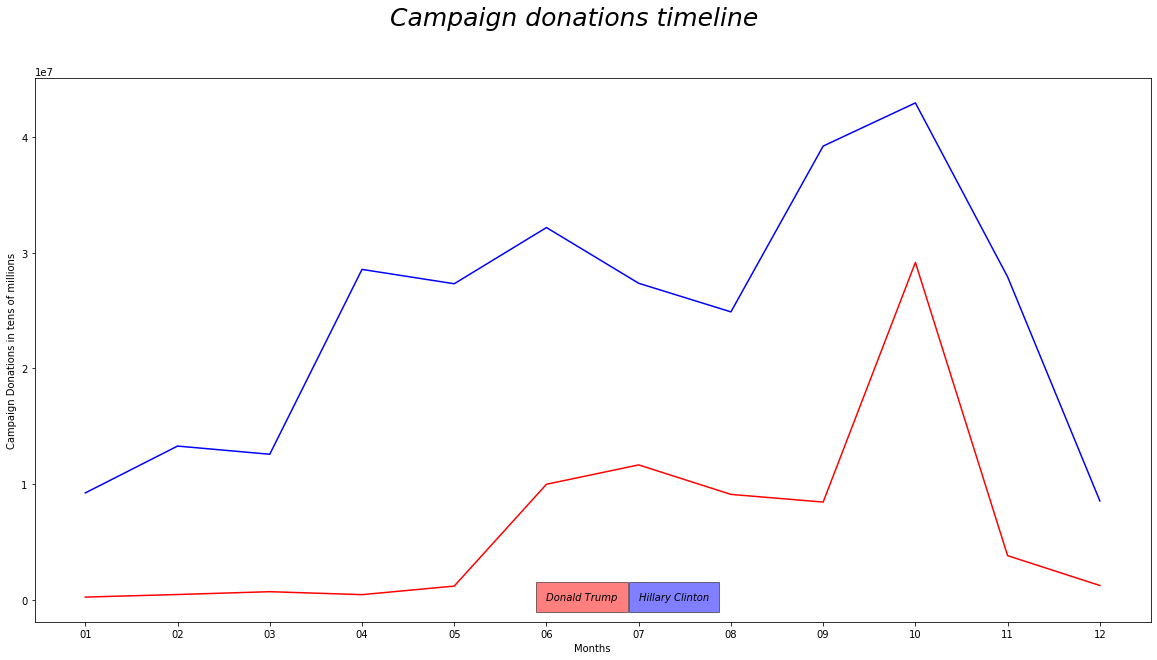

In [28]:

fig = plt.figure(figsize=(20,10))
fig.suptitle('Campaign donations timeline',fontsize = 25, style = 'italic')
ax = fig.add_subplot(111)

ax.text(5, 8, 'Donald Trump', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax.text(6, 2, 'Hillary Clinton', style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})

ax.set_xlabel('Months')
ax.set_ylabel('Campaign Donations in tens of millions')
fig2 = plt.plot(hillarymonths2, color = 'b')
plt.plot(trumpmonths2, color = 'r')


The campaign donations peak in October, which is one month before the elections.

#  Campaign Expenditures



Downloading headers and .csv file for operating expenditures from https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip . Setting all values as Strings except the transaction amount which is a float. Limiting report year to 2016.

In [29]:
expheaders2 = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv')
expheaders = expheaders2.columns.tolist()
datatypes3 = {header: np.str for header in expheaders}
datatypes3['TRANSACTION_AMT'] = np.float
exp = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip', sep = "|", index_col = False, names = expheaders, dtype = datatypes3)
exp = exp.loc[exp['RPT_YR'] == '2016']
exp

,CMTE_ID,AMNDT_IND,RPT_YR,RPT_TP,IMAGE_NUM,LINE_NUM,FORM_TP_CD,SCHED_TP_CD,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_PGI,PURPOSE,CATEGORY,CATEGORY_DESC,MEMO_CD,MEMO_TEXT,ENTITY_TP,SUB_ID,FILE_NUM,TRAN_ID,BACK_REF_TRAN_ID
293829,C00301838,N,2016,12P,201603039009643025,17,F3,SB,MT. AIRY PROPERTIES,CINCINNATI,OH,45239,01/04/2016,1421.00,P2016,RENT,NaN,NaN,NaN,NaN,ORG,4030420161276067742,1053182,B27436FA8FA1845B28A0,NaN
293830,C00301838,N,2016,12P,201603039009643025,17,F3,SB,HARRIS DISTRIBUTING,CINCINNATI,OH,45232,01/04/2016,450.00,P2016,STORAGE PAYMENT,NaN,NaN,NaN,NaN,ORG,4030420161276067743,1053182,BF7AC39DA8E9741F6A52,NaN
293831,C00301838,N,2016,12P,201603039009643025,17,F3,SB,HAMILTON COUNTY REPUBLICAN PARTY,CINCINNATI,OH,45202,01/06/2016,680.00,P2016,LINCOLN DAY DINNER TICKETS,NaN,NaN,NaN,NaN,COM,4030420161276067744,1053182,BE04F13706EFA4E3E867,NaN
293832,C00301838,N,2016,12P,201603039009643026,17,F3,SB,HAMILTON COUNTY REPUBLICAN PARTY,CINCINNATI,OH,45202,01/13/2016,193.06,P2016,POSTAGE REIMBURSEMENT,NaN,NaN,NaN,NaN,COM,4030420161276067745,1053182,B1F5025E7076641B0986,NaN
293833,C00301838,N,2016,12P,201603039009643026,17,F3,SB,RIGHT TURN DESIGN,EVANS MILLS,NY,136373320,01/15/2016,1630.00,P2016,ON-LINE CONSULTING,NaN,NaN,NaN,NaN,ORG,4030420161276067746,1053182,B81637DB52CEC48A9AC5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747277,C00000935,A,2016,YE,201708079070295371,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,12/19/2016,4452.68,NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878024,1178153,SB21B-957122,NaN
1747278,C00000935,A,2016,YE,201708079070295371,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,12/19/2016,7615.24,NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878026,1178153,SB21B-957123,NaN
1747279,C00000935,A,2016,YE,201708079070295371,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,12/19/2016,30210.07,NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878028,1178153,SB21B-957124,NaN
1747280,C00000935,A,2016,YE,201708079070295372,21B,F3X,SB,"THE SEXTON GROUP PUBLIC AFFAIRS, LLC",CHICAGO,IL,60654,12/19/2016,2548.67,NaN,GENERIC CMTE. TELEMARKETING,NaN,NaN,NaN,NaN,ORG,4080820171442878030,1178153,SB21B-957125,NaN


Simplyfying date to contain only month.

In [30]:
exp['TRANSACTION_DT'] = exp['TRANSACTION_DT'].astype(str)
exp['TRANSACTION_DT'] = exp['TRANSACTION_DT'].apply(lambda x : x[0] + x[1] )
exp.sample(10)

,CMTE_ID,AMNDT_IND,RPT_YR,RPT_TP,IMAGE_NUM,LINE_NUM,FORM_TP_CD,SCHED_TP_CD,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_PGI,PURPOSE,CATEGORY,CATEGORY_DESC,MEMO_CD,MEMO_TEXT,ENTITY_TP,SUB_ID,FILE_NUM,TRAN_ID,BACK_REF_TRAN_ID
1531798,C00031088,N,2016,M5,201605209016003902,21B,F3X,SB,EVENTBRITE,SAN FRANCISCO,CA,941071532,04,0.75,NaN,EVENTBRITE PROCESSING FEES,NaN,NaN,NaN,NaN,ORG,4052320161293082520,1073988,B9E80FD9E56744EA6B49,NaN
594200,C00612093,N,2016,Q2,201607120200215233,17,F3,SB,FEDEX OFFICE,MENLO PARK,CA,94025,06,0.42,P2016,POSTAGE,001,Administrative/Salary/Overhead Expenses,NaN,SB17.4510,NaN,2080120161307741596,1091018,SB072616523315,NaN
563192,C00605667,N,2016,Q3,201610149032531833,17,F3,SB,"JACKSON, TYLER",HARTSVILLE,SC,295504924,07,400.00,G2016,SALARY,001,Administrative/Salary/Overhead Expenses,NaN,NaN,IND,4110820161346847081,1107427,VSFVR9T84C2,NaN
779656,C00505065,N,2016,12P,201604149012415398,17,F3,SB,PAYCHEX,ROCHESTER,NY,146252311,01,13.12,P2016,WORKERS' COMPENSATION,NaN,NaN,NaN,NaN,ORG,4042920161284515656,1061860,VPEFCA171F2,NaN
1703326,C00573261,A,2016,Q1,201606079017487577,21B,F3X,SB,MAIL MONITOR APP,PHOENIX,AZ,850042686,03,149.00,NaN,SOFTWARE,NaN,NaN,NaN,NaN,ORG,4060820161294926366,1076527,VPEP0A1PN87,NaN
763125,C00531285,N,2016,Q1,201604159012425506,17,F3,SB,VIC AND ANTHONY'S,HOUSTON,TX,770023626,02,3678.92,G2016,EVENT EXPENSES,007,Campaign Event Expenses,X,NaN,ORG,4041820161283420445,1062129,BCD56768DAE304F7EAD0,B55F1230CE6F4450F894
836111,C00436386,A,2016,YE,201702020200051214,17,F3,SB,"LITTLE, RIATA",CASPER,WY,82609,12,145.00,P2018,REIMBURSE RIATA LITTLE,NaN,NaN,NaN,SEE ITRMIZATION,IND,1111520170035995389,1147605,SB0204171214264,NaN
1382565,C00341396,A,2016,Q3,201705239055141241,21B,F3X,SB,"COUSINS, SARAH",SHARON,CT,06069,08,50.00,NaN,EMPLOYEE BENEFITS,NaN,NaN,X,NaN,IND,4052320171405727557,1163964,SB21B.9513.1,SB21B.9513
1481179,C00042366,A,2016,M10,201610240200559398,21B,F3X,SB,BRAINTREE,CHICAGO,IL,60654,09,555.69,NaN,CREDIT CARD PROCESSING FEES,NaN,NaN,NaN,NaN,NaN,1021320170033676959,1141331,SB012517939865430,NaN
357961,C00614214,A,2016,12P,201701309041575130,17,F3,SB,PATRIOT RADIO COMMUNICATIONS,PETOSKEY,MI,49770,07,6000.00,P2016,RADIO ADVERTISING,NaN,NaN,NaN,NaN,ORG,4020220171369306132,1143920,SB17.4979,NaN


Merging with committee dataframe, then merging the resulting dataframe with the candidates dataframe.

In [31]:
exp = pd.merge(exp, 
               cm[['CMTE_ID', 'CMTE_NM', 'CAND_ID']], 
               on='CMTE_ID',
               how='inner')

exp = pd.merge(exp, 
               cn[['CAND_ID', 'CAND_NAME']], 
               on='CAND_ID',
               how='inner')

exp.head(5)

,CMTE_ID,AMNDT_IND,RPT_YR,RPT_TP,IMAGE_NUM,LINE_NUM,FORM_TP_CD,SCHED_TP_CD,NAME,CITY,STATE,ZIP_CODE,TRANSACTION_DT,TRANSACTION_AMT,TRANSACTION_PGI,PURPOSE,CATEGORY,CATEGORY_DESC,MEMO_CD,MEMO_TEXT,ENTITY_TP,SUB_ID,FILE_NUM,TRAN_ID,BACK_REF_TRAN_ID,CMTE_NM,CAND_ID,CAND_NAME
0,C00575449,A,2016,M2,201603319012213385,23,F3P,SB,GOOGLE,MOUNTAIN VIEW,CA,940431351,01,1106.91,P2016,SOFTWARE,NaN,NaN,X,NaN,ORG,4040120161281950242,1057798,B99D3E07795F04E22BF0,BB70194CEB7F042618CB,"RAND PAUL FOR PRESIDENT, INC.",P40003576,"PAUL, RAND"
1,C00575449,A,2016,M2,201603319012213383,23,F3P,SB,BILL.COM,PALO ALTO,CA,943033308,01,157.00,P2016,SOFTWARE,NaN,NaN,X,NaN,ORG,4040120161281950232,1057798,BE478E4A490A94FC9A49,BB70194CEB7F042618CB,"RAND PAUL FOR PRESIDENT, INC.",P40003576,"PAUL, RAND"
2,C00575449,A,2016,M2,201603319012213383,23,F3P,SB,RADISSON,OMAHA,NE,681643814,01,71.86,P2016,MEETING EXPENSE,NaN,NaN,X,NaN,ORG,4040120161281950234,1057798,BCB31D4EE69C94E0CA91,BB70194CEB7F042618CB,"RAND PAUL FOR PRESIDENT, INC.",P40003576,"PAUL, RAND"
3,C00575449,A,2016,M2,201603319012213384,23,F3P,SB,AMERICAN AIRLINES,FORT WORTH,TX,761552605,01,1152.10,P2016,AIRFARE,NaN,NaN,X,NaN,ORG,4040120161281950236,1057798,B351CC6FA540F477C955,BB70194CEB7F042618CB,"RAND PAUL FOR PRESIDENT, INC.",P40003576,"PAUL, RAND"
4,C00575449,A,2016,M2,201603319012213459,23,F3P,SB,MCDONALDS,OAK BROOK,IL,605235500,01,47.50,P2016,MEETING EXPENSE,NaN,NaN,X,NaN,ORG,4040120161281950690,1057798,BBA73EC70A8654F7B852,BA51A987E184E4969B50,"RAND PAUL FOR PRESIDENT, INC.",P40003576,"PAUL, RAND"


Limiting transaction amount to only positive values. Simplyfying names. Creating two new dataframes for each candidate.

In [32]:
(exp['TRANSACTION_AMT'] > 0).value_counts()
exp = exp[exp['TRANSACTION_AMT'] > 0]
exp.loc[exp['CAND_NAME'] == 'TRUMP, DONALD J. / MICHAEL R. PENCE ', 'CAND_NAME'] = 'TRUMP, DONALD J.'
exp.loc[exp['CAND_NAME'] == 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE', 'CAND_NAME'] = 'CLINTON, HILLARY RODHAM'
exptrump = exp.loc[exp['CAND_NAME'].isin(['TRUMP, DONALD J.'])].copy()
exphillary = exp.loc[exp['CAND_NAME'].isin(['CLINTON, HILLARY RODHAM'])].copy()



Creating a pivot table for each candidates dataframe. We are summing the transaction amounts of the operational expenses for each month of the year.

In [33]:
exptrump2 = exptrump.pivot_table(index = 'TRANSACTION_DT', columns = 'CAND_NAME' , values = 'TRANSACTION_AMT', aggfunc = 'sum')
exphillary2 = exphillary.pivot_table(index = 'TRANSACTION_DT', columns = 'CAND_NAME' , values = 'TRANSACTION_AMT', aggfunc = 'sum')
exphillary2

CAND_NAME,"CLINTON, HILLARY RODHAM"
TRANSACTION_DT,
01,2.082719e+07
02,3.289934e+07
03,3.004337e+07
04,2.370259e+07
05,1.596996e+07
06,3.557824e+07
07,3.983832e+07
08,5.081814e+07
09,8.441857e+07


Creating plot to represent the campaign expenses timeline.

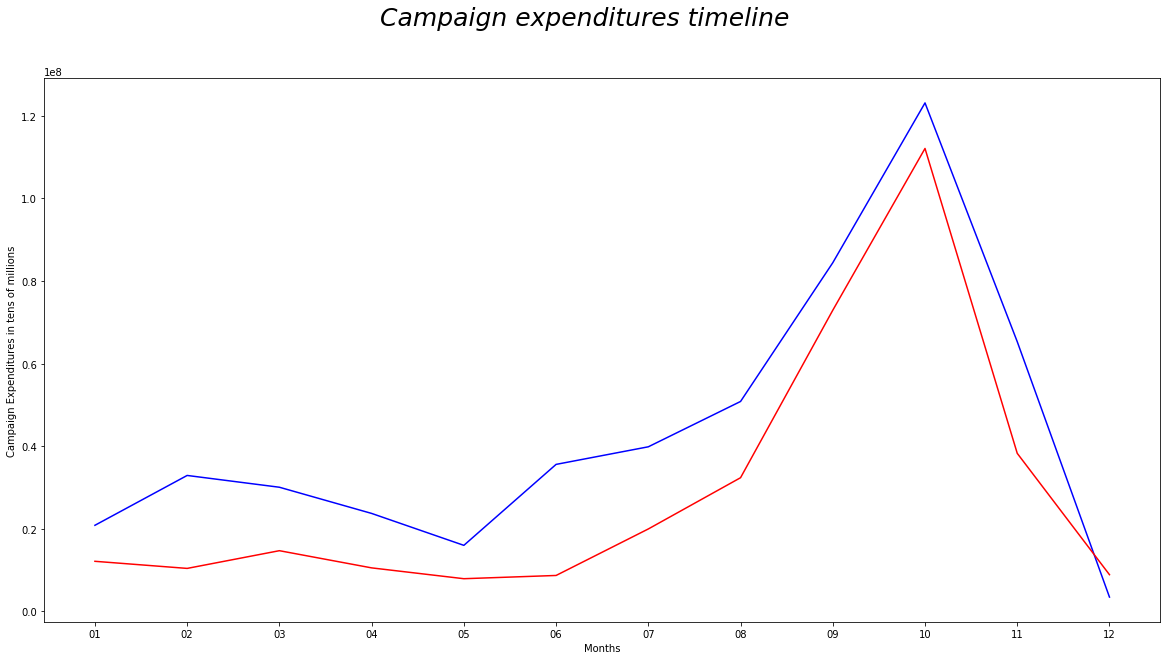

In [34]:
fig3 = plt.figure(figsize=(20,10))
fig3.suptitle('Campaign expenditures timeline',fontsize = 25, style = 'italic')
ax = fig3.add_subplot(111)



ax.set_xlabel('Months')
ax.set_ylabel('Campaign Expenditures in tens of millions')
fig4 = plt.plot(exphillary2, color = 'b')
plt.plot(exptrump2, color = 'r')

Similarly to the donations, the campaign expenditures peak in October, one month before the elections.

# Question 4 Identifying the biggest recipients of campaign expenditures.

We are going to use the dataframe from the previous question that contains all transactions for operating expenditures.
We are going to group them by name and present them with descending transaction amount totals.

In [35]:
exppl = exp\
    .groupby('NAME').sum()\
    .sort_values(by='TRANSACTION_AMT', ascending=False).head(15)
exppl

,TRANSACTION_AMT
NAME,
GMMB,2.963928e+08
GILES-PARSCALE,8.779947e+07
AMERICAN MEDIA & ADVOCACY GROUP,7.417638e+07
OLD TOWNE MEDIA INC,7.243631e+07
AMERICAN EXPRESS,5.174325e+07
BULLY PULPIT INTERACTIVE LLC,2.746582e+07
"RICK REED MEDIA, INC.",2.404784e+07
"REVOLUTION MESSAGING, LLC",1.931651e+07
WESTROGERS LLC,1.906004e+07


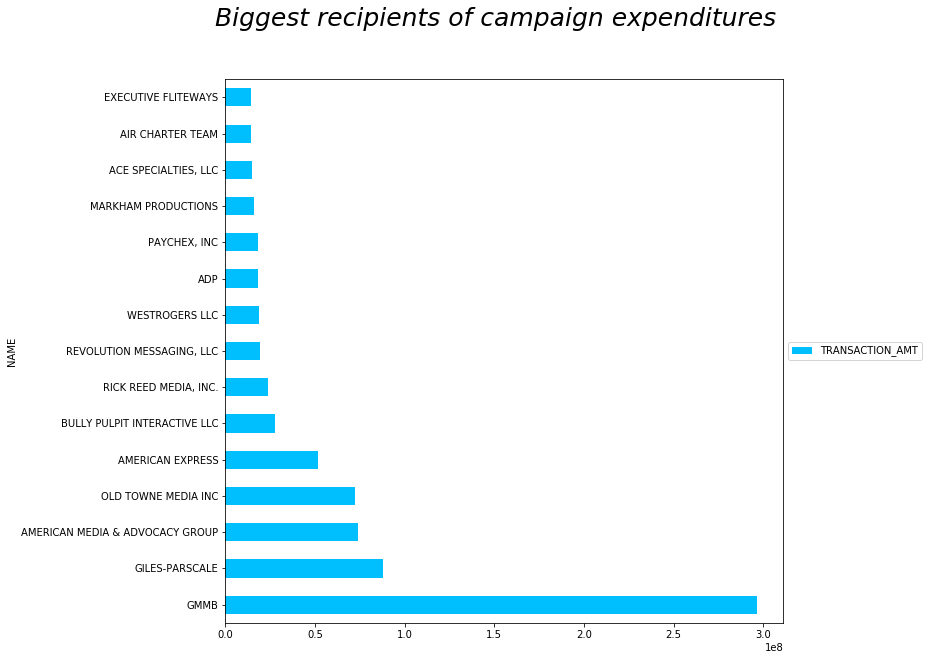

In [36]:
f = plt.figure(figsize=(10,10))
exppl.plot(kind='barh', stacked=True, ax=f.gca(), color=('deepskyblue', 'salmon'))
f.suptitle('Biggest recipients of campaign expenditures',fontsize = 25, style = 'italic')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Question 5 Examine the geographical distribution, at the state level, of campaign expenditures. For each state, calculate the expenditures per voter. This will require that you find a source with the number of registered voters per state. Examine the situation for swing states.

We are going to use the dataframe from the previous question that contains campaign expenditures. We are going to create a new dataframe that contains the sum of the transaction amounts for each state.

In [37]:
states =  exp.pivot_table(index = 'STATE' , values = 'TRANSACTION_AMT', aggfunc = 'sum')
states.head(10)

,TRANSACTION_AMT
STATE,
AK,163602.72
AL,3071820.05
AR,16943971.32
AS,2500.00
AZ,5229888.36
BC,3741.65
CA,39698706.75
CO,6569583.91
CT,11431270.38


We are going to create a dataframe that contains the registered voters for each state. You can find this data here https://www2.census.gov/programs-surveys/cps/tables/p20/580/table04a.xlsx

In [38]:

regvotes = pd.read_excel('https://www2.census.gov/programs-surveys/cps/tables/p20/580/table04a.xlsx')
reg = regvotes.drop(0)
reg = reg.drop(1)
reg = reg.drop(2)
reg = reg.drop(3)
reg = reg.drop(4)
reg = reg.drop(56)

reg = reg.drop(57)
reg = reg.drop(58)

voters = reg['Unnamed: 3'].to_list()
statess = reg['Table with row headers in column A, and column headers in rows 4 through 5.'].to_list()
pa = pd.DataFrame(voters,statess,columns= ['STATES'])
pa.reset_index(inplace = True)

mapp = {
   'ALABAMA':'AL','ALASKA':'AK','ARIZONA':'AZ','ARKANSAS':'AK','CALIFORNIA':'CA','COLORADO':'CO','CONNECTICUT':'CT','DELAWARE':'DL','DISTRICT OF COLUMBIA':'DC',
 'FLORIDA':'FL','GEORGIA':'GA','HAWAII':'HI','IDAHO':'ID','ILLINOIS':'IL','INDIANA':'IA','IOWA':'IA','KANSAS':'KS','KENTUCKY':'KY','LOUISIANA':'LA','MAINE':'ME',
 'MARYLAND':'MD','MASSACHUSETTS':'MA','MICHIGAN':'MI','MINNESOTA':'MN','MISSISSIPPI':'MS','MISSOURI':'MO','MONTANA':'MT','NEBRASKA':'NE','NEVADA':'NV',
 'NEW HAMPSHIRE':'NH','NEW JERSEY':'NJ','NEW MEXICO':'NM','NEW YORK':'NY','NORTH CAROLINA':'NC','NORTH DAKOTA':'ND','NORTHERN MARIANA ISLANDS':'MP',
 'OHIO':'OH','OKLAHOMA':'OK','OREGON':'OR','PENNSYLVANIA':'PA','RHODE ISLAND':'RI','SOUTH CAROLINA':'SC','SOUTH DAKOTA':'SD','TENNESSEE':'TN','TEXAS':'TX',
 'UTAH':'UT','VERMONT':'VT','VIRGINIA':'VA','WASHINGTON':'WA','WEST VIRGINIA':'WV','WISCONSIN':'WI','WYOMING':'WY'
}


f = lambda x : mapp.get(x,x)
pa.loc[:,'index'] = pa.loc[:,'index'].map(f)
pa.columns = ['STATE','RegVoters']
regvot = pa
regvot

,STATE,RegVoters
0,AL,2526
1,AK,358
2,AZ,3145
3,AK,1456
4,CA,16096
5,CO,2893
6,CT,1763
7,DL,487
8,DC,420
9,FL,9604


Merging the two dataframes. Passing the column RegVoters to states dataframe

In [39]:
states = pd.merge(states, 
               regvot[['STATE', 'RegVoters']], 
               on='STATE',
               how='inner')


Creating new column called AverageContrPerState, to create this we divide the transaction amount with the registered voters for each state. This column represents the average expenditure per voter for each state.

In [40]:
states = states.assign(AverageContrPerState = lambda x : (x['TRANSACTION_AMT']/x['RegVoters']))
states.head(10)

,STATE,TRANSACTION_AMT,RegVoters,AverageContrPerState
0,AK,1.636027e+05,358,456.990838
1,AK,1.636027e+05,1456,112.364505
2,AL,3.071820e+06,2526,1216.080780
3,AZ,5.229888e+06,3145,1662.921577
4,CA,3.969871e+07,16096,2466.370946
5,CO,6.569584e+06,2893,2270.855137
6,CT,1.143127e+07,1763,6483.987737
7,DC,3.844590e+08,420,915378.619500
8,FL,2.853242e+07,9604,2970.889186
9,GA,6.053579e+06,4892,1237.444659


Limiting DC average expenditures for better visualisation. Creating a new dataframe called swingstates that only contains the average expenditures for each state, sorted descendingly. Setting swingstate index to STATE.

In [41]:
states.loc[states['STATE'] == 'DC','AverageContrPerState'] = 200000

states = states.astype({"AverageContrPerState" : float})
swingstates = states.sort_values(by='AverageContrPerState', ascending = False)

swingstates.set_index('STATE',inplace=True, drop=True)

del swingstates['RegVoters']
del swingstates['TRANSACTION_AMT']
swingstates.head(15)

,AverageContrPerState
STATE,
DC,200000.000000
VA,48917.938829
NH,18704.357497
NJ,17379.203894
VT,12151.856268
NY,12071.183612
TX,9720.583808
UT,8219.903212
LA,6731.131823


# Average campaign expenditures based on state.

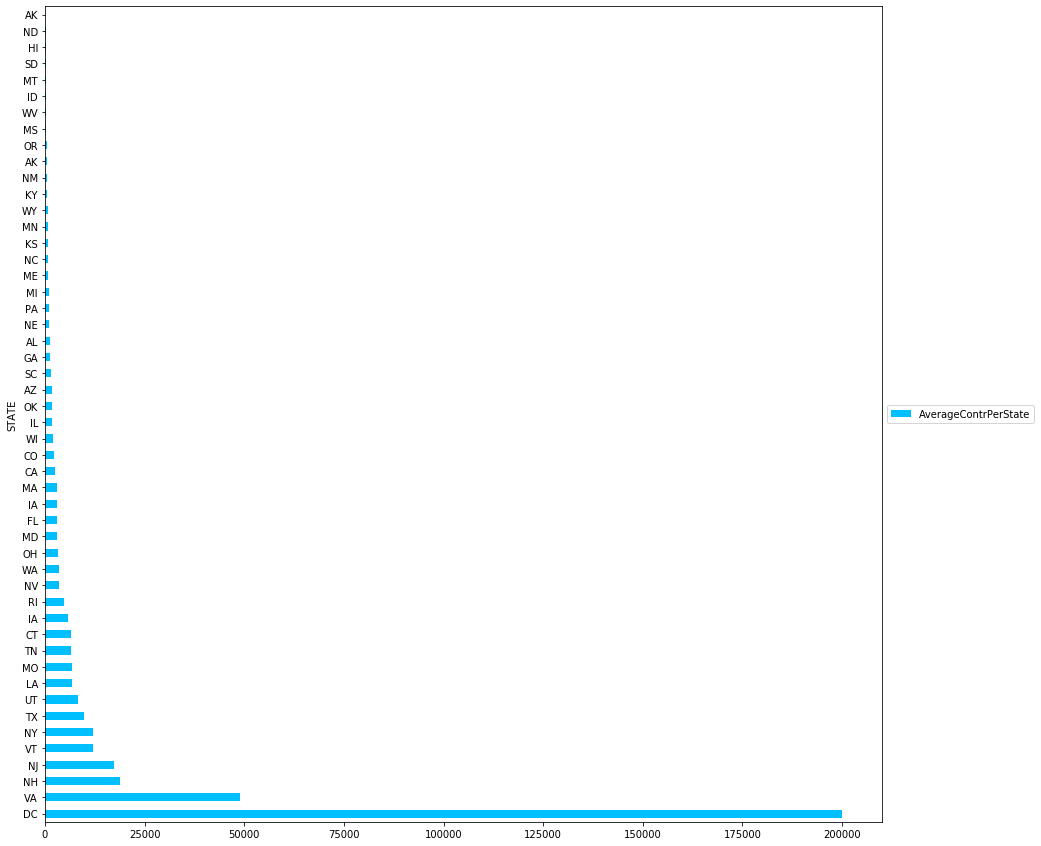

In [42]:

f = plt.figure(figsize=(15,15))

swingstates.plot(kind='barh', stacked=True, ax=f.gca(), color=('deepskyblue', 'salmon'))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Let's see the top 15 states.

In [43]:
swingstates.head(20)

,AverageContrPerState
STATE,
DC,200000.000000
VA,48917.938829
NH,18704.357497
NJ,17379.203894
VT,12151.856268
NY,12071.183612
TX,9720.583808
UT,8219.903212
LA,6731.131823


We can find the swing states from the 2016 election from https://en.wikipedia.org/wiki/Swing_state. We can see that apart from the Capital of the United States of America(DC) most of top ranking states based on average expenditures were deemed to be swing states such as VA, PA, NH, IA. This shows us the intent, the political campaigns had in expending the majority of their finances in states that will determine the final outcome.

Visualising results in USA map with cartopy.

Importing preprocessing from sklearn. Normalizing expenditures per voter between 0 and 1.

In [44]:

x = states[['AverageContrPerState']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)



Creating new dataframe that contains normalized average expenditures. Join new normalized dataset with the dataset that contains the state names(states). Setting column 'STATES' as new index.

In [45]:
df_normalized = pd.DataFrame(x_scaled)
df_normalized[0].astype(float)
df = df_normalized.join(states, how='outer')
df.set_index('STATE',inplace=True, drop=True)

df.head(5)

,0,TRANSACTION_AMT,RegVoters,AverageContrPerState
STATE,,,,
AK,0.001724,163602.72,358,456.990838
AK,0.000000,163602.72,1456,112.364505
AL,0.005522,3071820.05,2526,1216.080780
AZ,0.007757,5229888.36,3145,1662.921577
CA,0.011777,39698706.75,16096,2466.370946


Creating new column that contains the colors for each state. The colors are determined based on the normalized value of each states expenditures per voter.

In [46]:
df['Color'] = np.where(df[0]>=0 , 'oldlace', 'black')
df.loc[df[0] >0.001, 'Color'] = 'navajowhite'
df.loc[df[0] >0.01, 'Color'] = 'orange'
df.loc[df[0] >0.05, 'Color'] = 'brown'
df.loc[df[0] >0.9, 'Color'] = 'black'

df.head(5)

,0,TRANSACTION_AMT,RegVoters,AverageContrPerState,Color
STATE,,,,,
AK,0.001724,163602.72,358,456.990838,navajowhite
AK,0.000000,163602.72,1456,112.364505,oldlace
AL,0.005522,3071820.05,2526,1216.080780,navajowhite
AZ,0.007757,5229888.36,3145,1662.921577,navajowhite
CA,0.011777,39698706.75,16096,2466.370946,orange


Visualising the data on the USA map. The bigger the expenditure per voter, the darker the color.

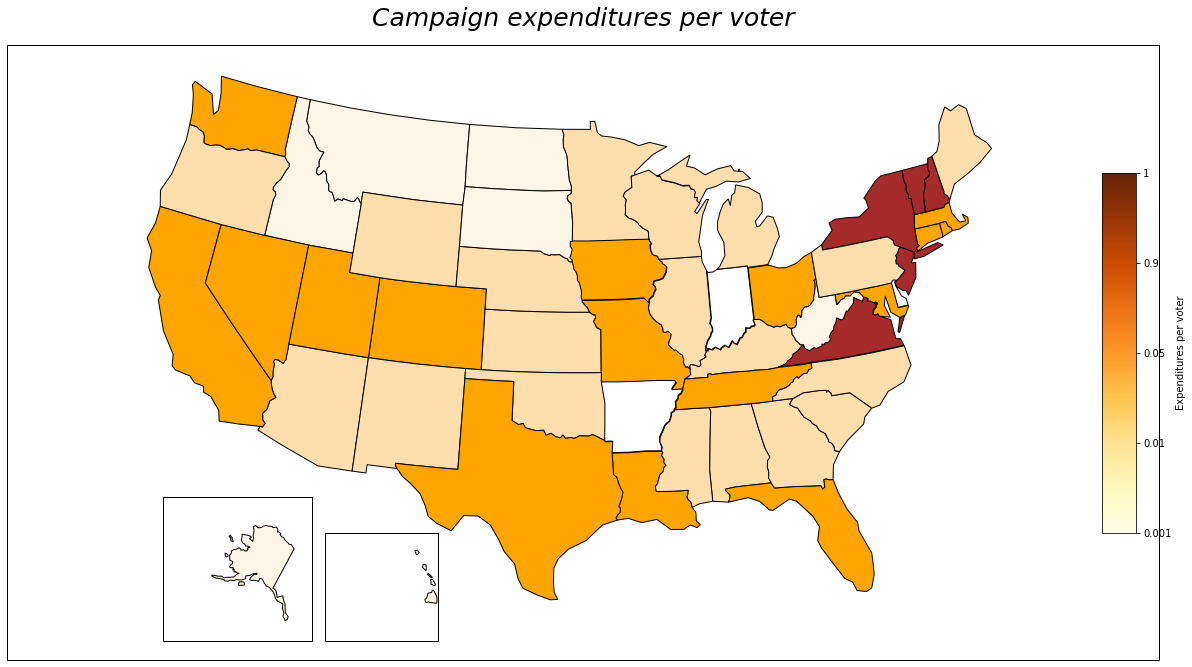

In [47]:
from matplotlib.colorbar import ColorbarBase
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Campaign expenditures per voter',fontsize = 25, style = 'italic')

projection=ccrs.LambertConformal()
# to get the effect of having just the states without a map "background"
# turn off the background patch and axes frame
ax = fig.add_axes([0, 0, 1, 1], projection=projection, frameon=False)
ax.patch.set_visible(False)
# Hawaii
axhi = fig.add_axes([0.25, .1, 0.15, 0.15], projection=projection)
axhi.set_extent([-155, -165, 20, 15])
axhi.patch.set_visible(False)
# Alaska
axak = fig.add_axes([0.1, 0.1, 0.2, 0.2], projection=projection)
axak.set_extent([-185, -130, 70, 50])
axak.patch.set_visible(False)

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

cmap = plt.cm.YlOrBr

for state in shpreader.Reader(states_shp).records():
    postal = state.attributes['postal']
    facecolor = df[df.index == postal]['Color'].values
    if postal == 'AK':
        axes = axak
    elif postal == 'HI':
        axes = axhi
    else:
        axes = ax
    axes.add_geometries([state.geometry], 
                        ccrs.PlateCarree(),
                        facecolor=facecolor,
                        linewidth=1,
                        edgecolor='black')
    
ax_c = fig.add_axes([.95, 0.25, 0.03, 0.5])
cb = ColorbarBase(ax_c, cmap=cmap, orientation='vertical',
                  label=r'Expenditures per voter')
cb.set_ticks([0, .25, .5, .75, 1])
cb.set_ticklabels(['0.001', '0.01', '0.05', '0.9', '1'])